In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore")
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic' # 예시: 맑은 고딕으로 설정 (Windows 환경 시)
plt.rcParams['axes.unicode_minus'] = False

In [5]:
data = pd.read_csv("C:/건강검진/health_checkup/JDM/2012년~2023년/건강조사_2012~2022_통합.csv") # 당뇨 치료

고혈압인데 고혈압 관리 안 한 사람 특징 확인

In [16]:
# 고혈압 전단계 또는 고혈압이면서 치료 안 한 사람만 남김
data = data[(data['HE_HP'].isin([3, 4])) & (data['DI1_pt'] == 0)]

In [ ]:
# 고혈압 전단계 또는 고혈압이면서 치료 안 한 사람만 남김
#data = data[(data['HE_DM_HbA1c'].isin([2, 3])) & (data['DE1_3'] == 2)]

In [10]:
data.info

<bound method DataFrame.info of                 mod_d             id       ID_fam    year  region  town_t  \
117     b'2022.03.08'  b'A110963502'  b'A1109635'  2012.0     1.0     1.0   
124     b'2022.03.08'  b'A110967702'  b'A1109677'  2012.0     1.0     1.0   
239     b'2022.03.08'  b'A112980901'  b'A1129809'  2012.0     1.0     1.0   
358     b'2022.03.08'  b'A115980303'  b'A1159803'  2012.0     1.0     1.0   
406     b'2022.03.08'  b'A117966901'  b'A1179669'  2012.0     1.0     1.0   
...               ...            ...          ...     ...     ...     ...   
83849  b'2024.01.11.'            NaN  b'YP015742'  2022.0    17.0     2.0   
83867  b'2024.01.11.'            NaN  b'YP132325'  2022.0    17.0     1.0   
83965  b'2024.01.11.'            NaN  b'YP384225'  2022.0    17.0     1.0   
84004  b'2024.01.11.'            NaN  b'YR133942'  2022.0     8.0     2.0   
84031  b'2024.01.11.'            NaN  b'YR137036'  2022.0     8.0     2.0   

       apt_t      psu  sex   age  age_month

In [17]:
import pandas as pd

# 남기고 싶은 컬럼 리스트
columns_to_keep = [
    'ID','year','age','sex','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1',
    'HE_Upro', 'HE_glu', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt',
    # 'L_OUT_FQ', 
    # 'BP1','BD1_11', 'BS3_2', 'BE5_1', 
    'HE_obe', 'HE_HP', 'HE_DM_HbA1c',
    'DE1_dg', 'DI1_dg',
    'DI1_pt'
]

# 원래 데이터프레임이 df일 때
data = data[columns_to_keep]


In [18]:
def iqr_clip(series, lower_quantile=0.25, upper_quantile=0.75, clip_range=1.5):
    q1 = series.quantile(lower_quantile)
    q3 = series.quantile(upper_quantile)
    iqr = q3 - q1
    lower_bound = q1 - clip_range * iqr
    upper_bound = q3 + clip_range * iqr
    return series.clip(lower=lower_bound, upper=upper_bound)

# 적용
data['HE_glu'] = iqr_clip(data['HE_glu'])
data['HE_alt'] = iqr_clip(data['HE_alt'])

In [20]:
# HE_DM_HbA1c
if 'HE_DM_HbA1c' in data.columns:
    data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DE1_dg' in data.columns:
        print(f"DE1_dg missing ratio: {data['DE1_dg'].isnull().mean()}")
        data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].fillna(data['DE1_dg'].map({0: 1, 1: 3}))
    # 남은 결측치는 드랍랍
    if data['HE_DM_HbA1c'].isnull().any():
        data = data[data['HE_DM_HbA1c'].notnull()]
    print(f"HE_DM_HbA1c NaN count after: {data['HE_DM_HbA1c'].isnull().sum()}")

# HE_obe
if 'HE_obe' in data.columns:
    data['HE_obe'] = data['HE_obe'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'HE_BMI' in data.columns:
        # BMI가 KNN 대체된 경우 표시
        data['HE_BMI_imputed'] = data['HE_BMI'].isnull().astype(int)
        data['HE_obe'] = data.apply(
            lambda row: row['HE_obe'] if pd.notna(row['HE_obe']) else (
                1 if row['HE_BMI'] < 18.5 else
                2 if row['HE_BMI'] < 25 else
                3 if row['HE_BMI'] < 30 else
                4 if row['HE_BMI'] < 35 else
                5 if row['HE_BMI'] < 40 else
                6
            ),
            axis=1
        )
    # 남은 결측치는 드랍랍
    if data['HE_obe'].isnull().any():
        data = data[data['HE_obe'].notnull()]
    print(f"HE_obe NaN count after: {data['HE_obe'].isnull().sum()}")

# HE_HP
if 'HE_HP' in data.columns:
    data['HE_HP'] = data['HE_HP'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DI1_dg' in data.columns:
        print(f"DI1_dg missing ratio: {data['DI1_dg'].isnull().mean()}")
        data['HE_HP'] = data['HE_HP'].fillna(data['DI1_dg'].map({0: 1, 1: 4}))
    # 남은 결측치는 드랍랍
    if data['HE_HP'].isnull().any():
        data = data[data['HE_HP'].notnull()]
    print(f"HE_HP NaN count after: {data['HE_HP'].isnull().sum()}")


#결측치 비율 낮은 변수 처리
# low_missing_columns = [
#     'DI1_dg', 
#     'DE1_dg', 
# ]
continuous_columns = ['HE_wt', 'HE_ht', 'HE_BMI']  # 연속형 변수

#for col in low_missing_columns + continuous_columns:
for col in continuous_columns:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].replace([9, 99, 999, 88, 888, 9.0, 99.0, 999.0, 88.0, 888.0], np.nan)
        if not data[col].isnull().all():
            if col in continuous_columns:
                median_value = data[col].median()
                data[col] = data[col].fillna(median_value)
                print(f"Median for {col}: {median_value}")
            else:
                mode_series = data[col].mode(dropna=True)
                if not mode_series.empty:
                    mode_value = mode_series[0]
                    data[col] = data[col].fillna(mode_value)
                    print(f"Mode for {col}: {mode_value}")
                else:
                    print(f"No valid mode for {col}, leaving as is.")
        else:
            print(f"Column {col} is all NaN, skipping.")

# data = data[data['DE1_3'].isin([1, 2])]

#생체 지표 결측치 처리
knn_columns = [
    'HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_chol',
    'HE_HDL_st2', 'HE_TG', 'HE_LDL_drct',  'HE_crea', 'HE_Upro',
    'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI'
]
knn_data = data[knn_columns].copy()
knn_data = knn_data.replace([888, 999, 888.0, 999.0], np.nan)

# 스케일링
scaler = StandardScaler()
knn_data_scaled = scaler.fit_transform(knn_data)
knn_data_scaled = pd.DataFrame(knn_data_scaled, columns=knn_columns, index=knn_data.index)

# KNN Imputation
imputer_knn = KNNImputer(n_neighbors=5, weights="distance")
knn_imputed = imputer_knn.fit_transform(knn_data_scaled)

# 역스케일링
knn_imputed = scaler.inverse_transform(knn_imputed)
knn_imputed_data = pd.DataFrame(knn_imputed, columns=knn_columns, index=knn_data.index)
data[knn_columns] = knn_imputed_data



DE1_dg missing ratio: 0.0
HE_DM_HbA1c NaN count after: 0
HE_obe NaN count after: 0
DI1_dg missing ratio: 0.0
HE_HP NaN count after: 0
Median for HE_wt: 64.6
Median for HE_ht: 164.4
Median for HE_BMI: 24.615231827515593


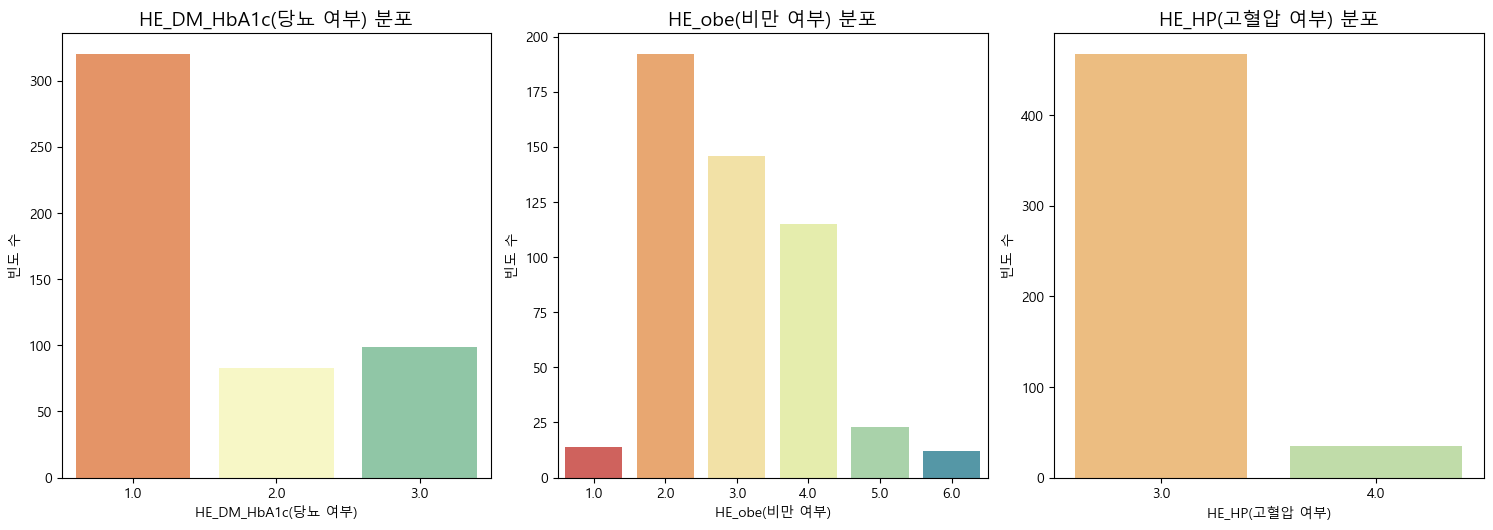

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화할 변수 리스트
targets = ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']
column_labels = {
    'HE_DM_HbA1c': 'HE_DM_HbA1c(당뇨 여부)',
    'HE_obe': 'HE_obe(비만 여부)',
    'HE_HP': 'HE_HP(고혈압 여부)'
}

# 서브플롯 설정 (2행 4열: 8개의 칸 중 3개 사용)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # 2차원 → 1차원 평탄화

# 각 변수에 대해 countplot 그리기
for i, var in enumerate(targets):
    sns.countplot(x=var, data=data, palette="Spectral", ax=axes[i])
    axes[i].set_title(f"{column_labels[var]} 분포", fontsize=14)
    axes[i].set_xlabel(column_labels[var])
    axes[i].set_ylabel('빈도 수')

# 사용하지 않는 subplot 숨기기
for j in range(len(targets), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


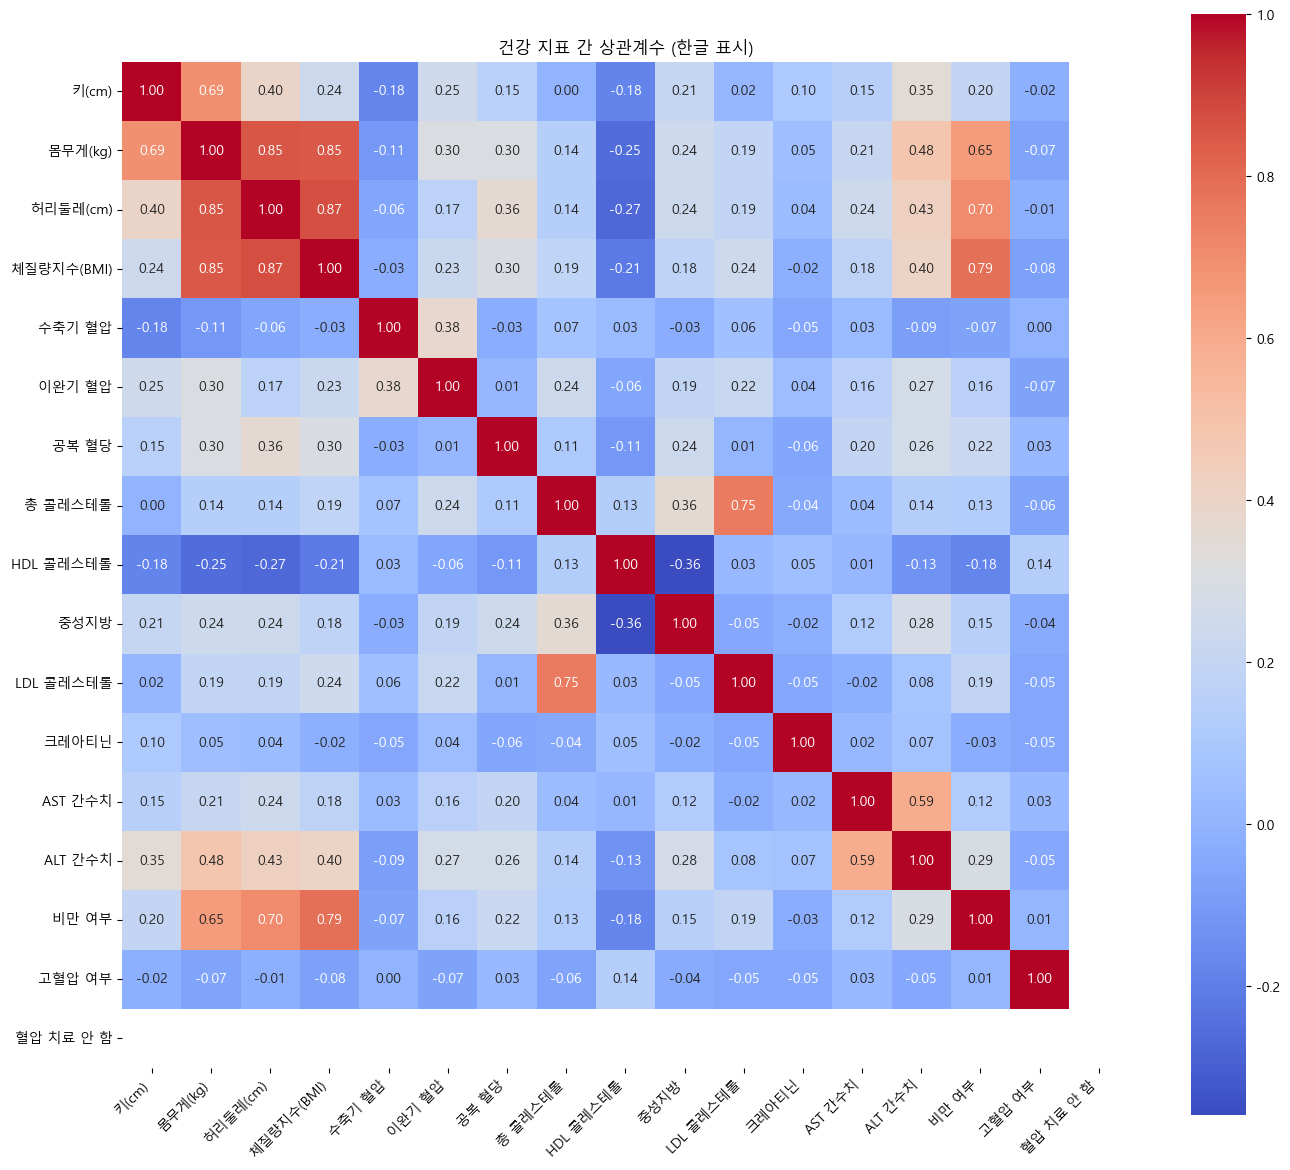

In [23]:
column_name_map = {
    'HE_ht': '키(cm)',
    'HE_wt': '몸무게(kg)',
    'HE_wc': '허리둘레(cm)',
    'HE_BMI': '체질량지수(BMI)',
    'HE_sbp1': '수축기 혈압',
    'HE_dbp1': '이완기 혈압',
    'HE_glu': '공복 혈당',
    'HE_chol': '총 콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤',
    'HE_TG': '중성지방',
    'HE_LDL_drct': 'LDL 콜레스테롤',
    'HE_crea': '크레아티닌',
    'HE_ast': 'AST 간수치',
    'HE_alt': 'ALT 간수치',
    'HE_obe': '비만 여부',
    'HE_HP': '고혈압 여부',
    'DI1_pt' : '혈압 치료 안 함'
}


correlation_columns = [
    'HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1', 'HE_glu', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'DE1_3', 'DI1_pt'
]

import seaborn as sns
import matplotlib.pyplot as plt

# 보고 싶은 변수만 추출
selected_columns = list(column_name_map.keys())
correlation_matrix = data[selected_columns].corr()

# 컬럼명을 한글로 변환
correlation_matrix.columns = [column_name_map[col] for col in correlation_matrix.columns]
correlation_matrix.index = [column_name_map[col] for col in correlation_matrix.index]

# 히트맵 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("건강 지표 간 상관계수 (한글 표시)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

📊 타겟 변수 상관 분석 - 고혈압


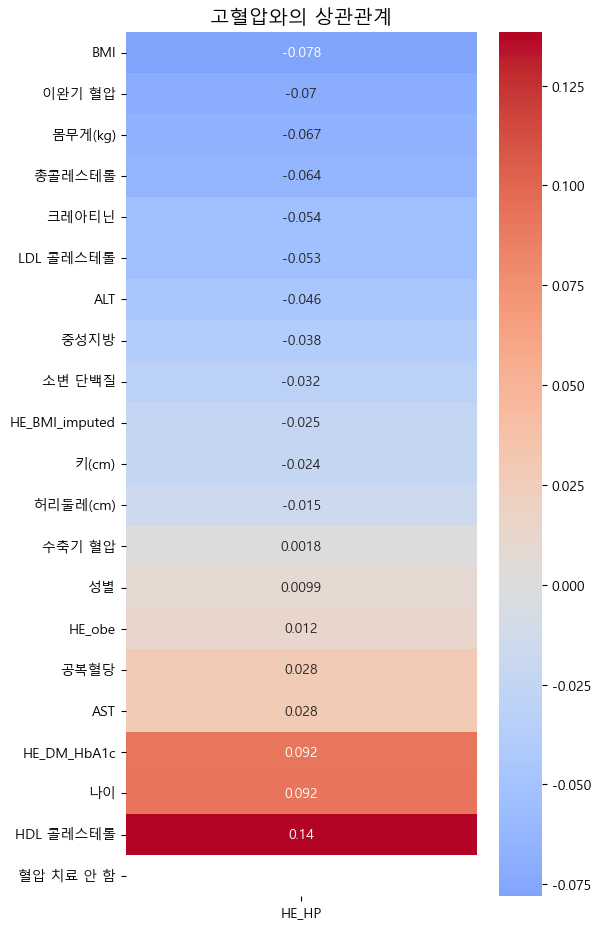

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# 변수 이름 -> 한글 매핑 사전
feature_name_ko = {
    'HE_ht': '키(cm)', 'HE_wt': '몸무게(kg)', 'HE_wc': '허리둘레(cm)', 'HE_BMI': 'BMI',
    'HE_sbp1': '수축기 혈압', 'HE_dbp1': '이완기 혈압',
    'HE_Upro': '소변 단백질', 'HE_glu': '공복혈당', 'HE_chol': '총콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤', 'HE_TG': '중성지방', 'HE_LDL_drct': 'LDL 콜레스테롤',
    'HE_crea': '크레아티닌', 'HE_ast': 'AST', 'HE_alt': 'ALT',
    'sex': '성별', 'age': '나이',
    'DI1_pt' : '혈압 치료 안 함'
}

# 타겟 이름 -> 한글 매핑
target_name_ko = {

    'HE_HP': '고혈압'
}

# 제외할 컬럼
exclude_cols = ['year', 'ID', 'DE1_dg', 'DI1_dg'] + list(target_name_ko.keys())

# input features 자동 지정
input_features = [col for col in data.columns if col not in exclude_cols]

for target in target_name_ko.keys():
    print(f"📊 타겟 변수 상관 분석 - {target_name_ko[target]}")
    
    # 수치형 변수만 포함한 데이터프레임
    subset = data[input_features + [target]].copy()
    subset = subset.select_dtypes(include='number')

    # 상관계수 계산
    corr_with_target = subset.corr()[[target]].drop(index=target)
    corr_with_target = corr_with_target.sort_values(by=target, ascending=True)

    # 한글 라벨로 인덱스 변환
    corr_with_target.index = [feature_name_ko.get(col, col) for col in corr_with_target.index]

    # 시각화
    plt.figure(figsize=(6, len(corr_with_target) * 0.4 + 1))
    sns.heatmap(corr_with_target, annot=True, cmap='coolwarm', center=0)
    plt.title(f"{target_name_ko[target]}와의 상관관계", fontsize=14)
    plt.tight_layout()
    plt.show()


고혈압인데 치료 안 한 사람을 드랍

In [51]:
data = pd.read_csv("C:/건강검진/health_checkup/JDM/2022년~2023년/건강조사_2012~2022_통합.csv") # 당뇨 치료

In [52]:
# 고혈압 전단계 또는 고혈압이면서 치료 안 한 사람만 버림
data = data[~((data['HE_HP'].isin([3, 4])) & (data['DI1_pt'] == 0))]

In [53]:
import pandas as pd

# 남기고 싶은 컬럼 리스트
columns_to_keep = [
    'ID','year','age','sex','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1',
    'HE_Upro', 'HE_glu', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt',
    # 'L_OUT_FQ', 
    # 'BP1','BD1_11', 'BS3_2', 'BE5_1', 
    'HE_obe', 'HE_HP', 'HE_DM_HbA1c',
    'DE1_dg', 'DI1_dg',
    'DI1_pt'
]

# 원래 데이터프레임이 df일 때
data = data[columns_to_keep]

In [54]:
def iqr_clip(series, lower_quantile=0.25, upper_quantile=0.75, clip_range=1.5):
    q1 = series.quantile(lower_quantile)
    q3 = series.quantile(upper_quantile)
    iqr = q3 - q1
    lower_bound = q1 - clip_range * iqr
    upper_bound = q3 + clip_range * iqr
    return series.clip(lower=lower_bound, upper=upper_bound)

# 적용
data['HE_glu'] = iqr_clip(data['HE_glu'])
data['HE_alt'] = iqr_clip(data['HE_alt'])

# HE_DM_HbA1c
if 'HE_DM_HbA1c' in data.columns:
    data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DE1_dg' in data.columns:
        print(f"DE1_dg missing ratio: {data['DE1_dg'].isnull().mean()}")
        data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].fillna(data['DE1_dg'].map({0: 1, 1: 3}))
    # 남은 결측치는 드랍랍
    if data['HE_DM_HbA1c'].isnull().any():
        data = data[data['HE_DM_HbA1c'].notnull()]
    print(f"HE_DM_HbA1c NaN count after: {data['HE_DM_HbA1c'].isnull().sum()}")

# HE_obe
if 'HE_obe' in data.columns:
    data['HE_obe'] = data['HE_obe'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'HE_BMI' in data.columns:
        # BMI가 KNN 대체된 경우 표시
        data['HE_BMI_imputed'] = data['HE_BMI'].isnull().astype(int)
        data['HE_obe'] = data.apply(
            lambda row: row['HE_obe'] if pd.notna(row['HE_obe']) else (
                1 if row['HE_BMI'] < 18.5 else
                2 if row['HE_BMI'] < 25 else
                3 if row['HE_BMI'] < 30 else
                4 if row['HE_BMI'] < 35 else
                5 if row['HE_BMI'] < 40 else
                6
            ),
            axis=1
        )
    # 남은 결측치는 드랍랍
    if data['HE_obe'].isnull().any():
        data = data[data['HE_obe'].notnull()]
    print(f"HE_obe NaN count after: {data['HE_obe'].isnull().sum()}")

# HE_HP
if 'HE_HP' in data.columns:
    data['HE_HP'] = data['HE_HP'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DI1_dg' in data.columns:
        print(f"DI1_dg missing ratio: {data['DI1_dg'].isnull().mean()}")
        data['HE_HP'] = data['HE_HP'].fillna(data['DI1_dg'].map({0: 1, 1: 4}))
    # 남은 결측치는 드랍랍
    if data['HE_HP'].isnull().any():
        data = data[data['HE_HP'].notnull()]
    print(f"HE_HP NaN count after: {data['HE_HP'].isnull().sum()}")


#결측치 비율 낮은 변수 처리
# low_missing_columns = [
#     'DI1_dg', 
#     'DE1_dg', 
# ]
continuous_columns = ['HE_wt', 'HE_ht', 'HE_BMI']  # 연속형 변수

#for col in low_missing_columns + continuous_columns:
for col in continuous_columns:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].replace([9, 99, 999, 88, 888, 9.0, 99.0, 999.0, 88.0, 888.0], np.nan)
        if not data[col].isnull().all():
            if col in continuous_columns:
                median_value = data[col].median()
                data[col] = data[col].fillna(median_value)
                print(f"Median for {col}: {median_value}")
            else:
                mode_series = data[col].mode(dropna=True)
                if not mode_series.empty:
                    mode_value = mode_series[0]
                    data[col] = data[col].fillna(mode_value)
                    print(f"Mode for {col}: {mode_value}")
                else:
                    print(f"No valid mode for {col}, leaving as is.")
        else:
            print(f"Column {col} is all NaN, skipping.")

# data = data[data['DE1_3'].isin([1, 2])]

#생체 지표 결측치 처리
knn_columns = [
    'HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_chol',
    'HE_HDL_st2', 'HE_TG', 'HE_LDL_drct',  'HE_crea', 'HE_Upro',
    'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI'
]
knn_data = data[knn_columns].copy()
knn_data = knn_data.replace([888, 999, 888.0, 999.0], np.nan)

# 스케일링
scaler = StandardScaler()
knn_data_scaled = scaler.fit_transform(knn_data)
knn_data_scaled = pd.DataFrame(knn_data_scaled, columns=knn_columns, index=knn_data.index)

# KNN Imputation
imputer_knn = KNNImputer(n_neighbors=5, weights="distance")
knn_imputed = imputer_knn.fit_transform(knn_data_scaled)

# 역스케일링
knn_imputed = scaler.inverse_transform(knn_imputed)
knn_imputed_data = pd.DataFrame(knn_imputed, columns=knn_columns, index=knn_data.index)
data[knn_columns] = knn_imputed_data



DE1_dg missing ratio: 0.05705428954423593
HE_DM_HbA1c NaN count after: 0
HE_obe NaN count after: 0
DI1_dg missing ratio: 0.0
HE_HP NaN count after: 0
Median for HE_wt: 62.2
Median for HE_ht: 162.5
Median for HE_BMI: 23.66419796690986


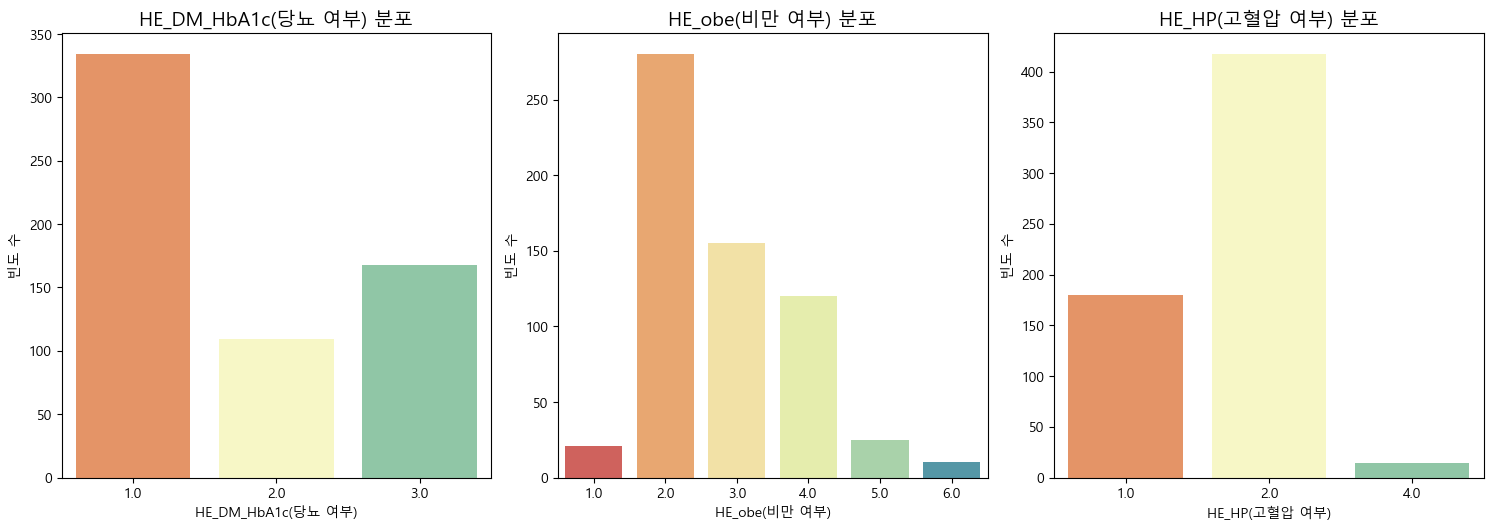

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화할 변수 리스트
targets = ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']
column_labels = {
    'HE_DM_HbA1c': 'HE_DM_HbA1c(당뇨 여부)',
    'HE_obe': 'HE_obe(비만 여부)',
    'HE_HP': 'HE_HP(고혈압 여부)'
}

# 서브플롯 설정 (2행 4열: 8개의 칸 중 3개 사용)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # 2차원 → 1차원 평탄화

# 각 변수에 대해 countplot 그리기
for i, var in enumerate(targets):
    sns.countplot(x=var, data=data, palette="Spectral", ax=axes[i])
    axes[i].set_title(f"{column_labels[var]} 분포", fontsize=14)
    axes[i].set_xlabel(column_labels[var])
    axes[i].set_ylabel('빈도 수')

# 사용하지 않는 subplot 숨기기
for j in range(len(targets), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


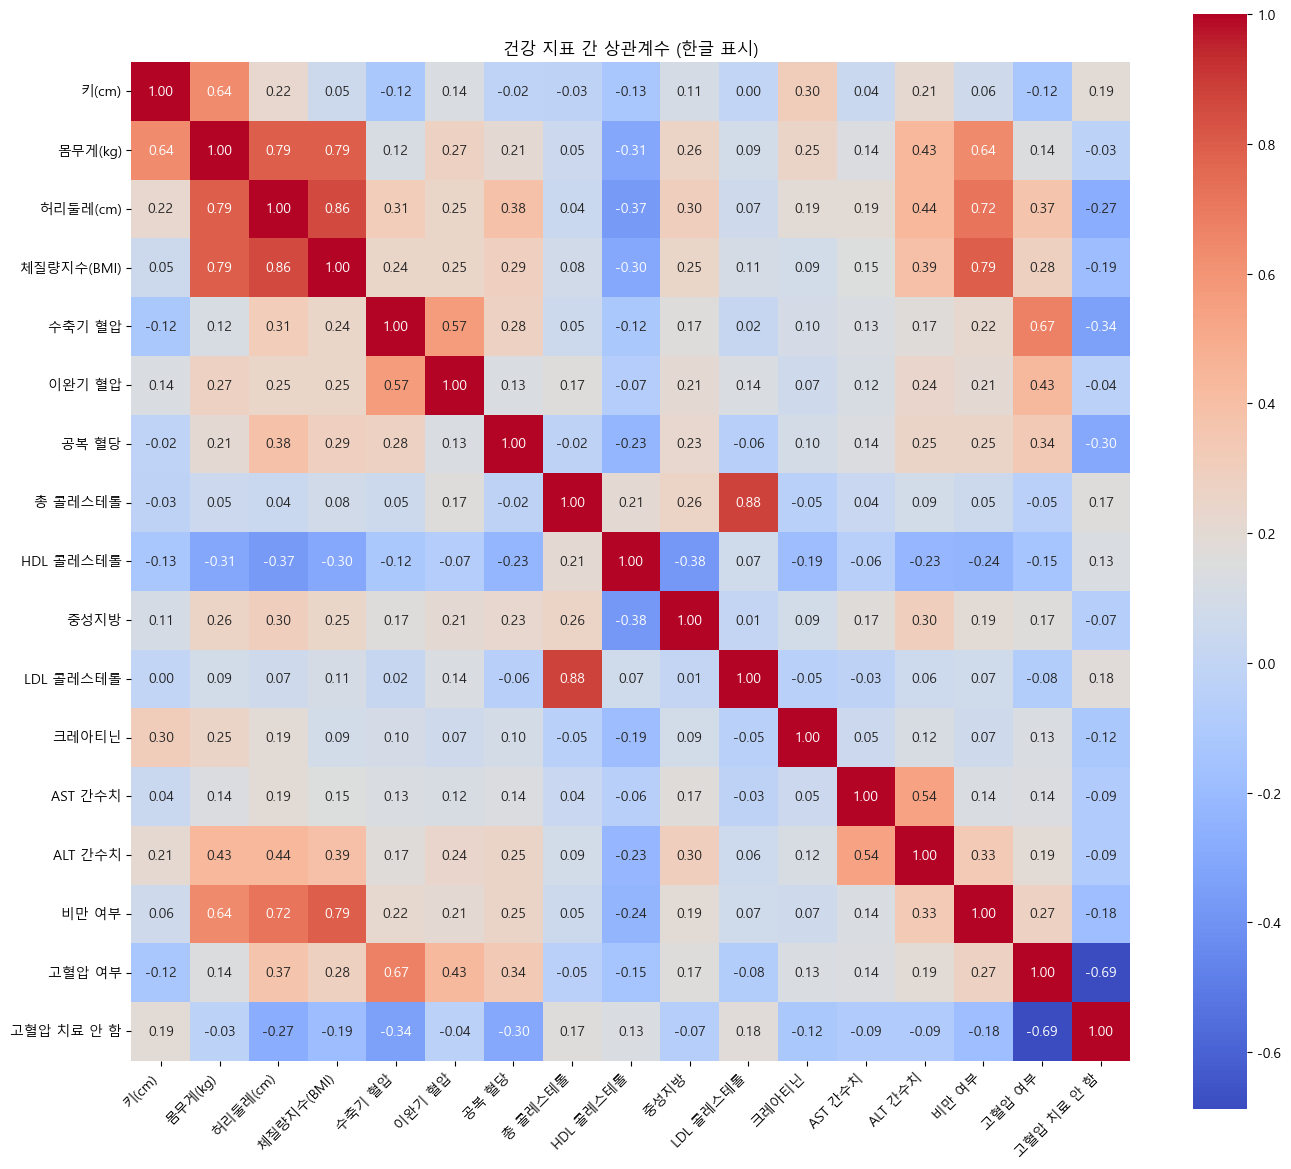

In [55]:
column_name_map = {
    'HE_ht': '키(cm)',
    'HE_wt': '몸무게(kg)',
    'HE_wc': '허리둘레(cm)',
    'HE_BMI': '체질량지수(BMI)',
    'HE_sbp1': '수축기 혈압',
    'HE_dbp1': '이완기 혈압',
    'HE_glu': '공복 혈당',
    'HE_chol': '총 콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤',
    'HE_TG': '중성지방',
    'HE_LDL_drct': 'LDL 콜레스테롤',
    'HE_crea': '크레아티닌',
    'HE_ast': 'AST 간수치',
    'HE_alt': 'ALT 간수치',
    'HE_obe': '비만 여부',
    'HE_HP': '고혈압 여부',
    'DI1_pt' : '고혈압 치료 안 함'
}


correlation_columns = [
    'HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1', 'HE_glu', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'DI1_pt'
]

import seaborn as sns
import matplotlib.pyplot as plt

# 보고 싶은 변수만 추출
selected_columns = list(column_name_map.keys())
correlation_matrix = data[selected_columns].corr()

# 컬럼명을 한글로 변환
correlation_matrix.columns = [column_name_map[col] for col in correlation_matrix.columns]
correlation_matrix.index = [column_name_map[col] for col in correlation_matrix.index]

# 히트맵 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("건강 지표 간 상관계수 (한글 표시)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

📊 타겟 변수 상관 분석 - 고혈압압


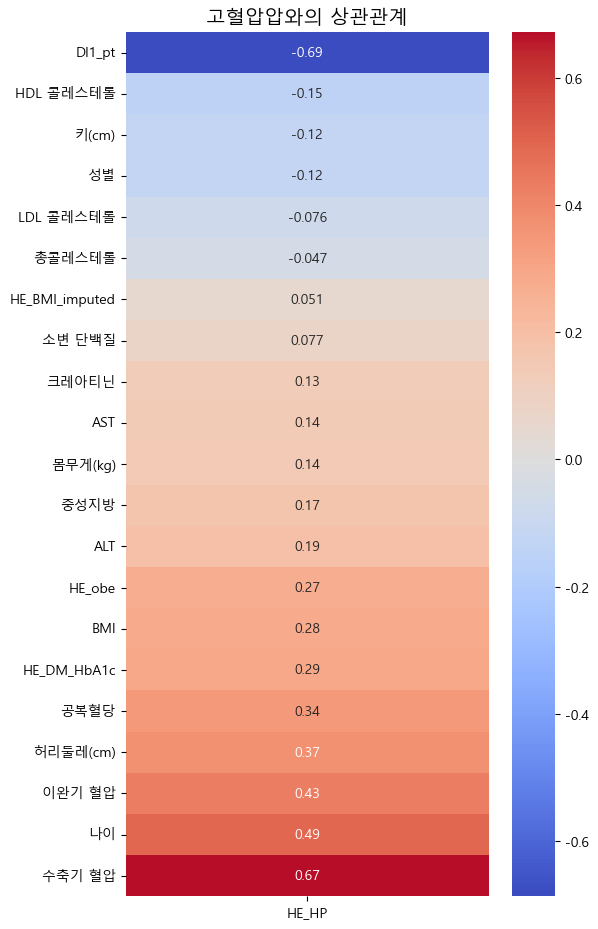

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# 변수 이름 -> 한글 매핑 사전
feature_name_ko = {
    'HE_ht': '키(cm)', 'HE_wt': '몸무게(kg)', 'HE_wc': '허리둘레(cm)', 'HE_BMI': 'BMI',
    'HE_sbp1': '수축기 혈압', 'HE_dbp1': '이완기 혈압',
    'HE_Upro': '소변 단백질', 'HE_glu': '공복혈당', 'HE_chol': '총콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤', 'HE_TG': '중성지방', 'HE_LDL_drct': 'LDL 콜레스테롤',
    'HE_crea': '크레아티닌', 'HE_ast': 'AST', 'HE_alt': 'ALT',
    'sex': '성별', 'age': '나이',
    'DE1_3' : '당뇨뇨 치료 안 함'
}

# 타겟 이름 -> 한글 매핑
target_name_ko = {

    'HE_HP': '고혈압압'
}

# 제외할 컬럼
exclude_cols = ['year', 'ID', 'DE1_dg', 'DI1_dg'] + list(target_name_ko.keys())

# input features 자동 지정
input_features = [col for col in data.columns if col not in exclude_cols]

for target in target_name_ko.keys():
    print(f"📊 타겟 변수 상관 분석 - {target_name_ko[target]}")
    
    # 수치형 변수만 포함한 데이터프레임
    subset = data[input_features + [target]].copy()
    subset = subset.select_dtypes(include='number')

    # 상관계수 계산
    corr_with_target = subset.corr()[[target]].drop(index=target)
    corr_with_target = corr_with_target.sort_values(by=target, ascending=True)

    # 한글 라벨로 인덱스 변환
    corr_with_target.index = [feature_name_ko.get(col, col) for col in corr_with_target.index]

    # 시각화
    plt.figure(figsize=(6, len(corr_with_target) * 0.4 + 1))
    sns.heatmap(corr_with_target, annot=True, cmap='coolwarm', center=0)
    plt.title(f"{target_name_ko[target]}와의 상관관계", fontsize=14)
    plt.tight_layout()
    plt.show()


가설 : 기존 데이터셋에는 고혈압인데 고혈압 압치료한 사람의 수치가 껴있어 변수들간에 상관계수를 방해한다. 상관계수를 확인해 보니 기존 데이터셋과 다를것이 없다.

당뇨인데 당뇨 관리 안 한 사람 특징 보기

In [30]:
data = pd.read_csv("C:/건강검진/health_checkup/JDM/2022년~2023년/건강조사_2012~2022_통합.csv") # 당뇨 치료

In [ ]:
# 당뇨뇨 전단계 또는 당뇨이면서 치료 안 한 사람만 남김
data = data[(data['HE_DM_HbA1c'].isin([2, 3])) & (data['DE1_3'] == 2)]

In [32]:
import pandas as pd

# 남기고 싶은 컬럼 리스트
columns_to_keep = [
    'ID','year','age','sex','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1',
    'HE_Upro', 'HE_glu', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt',
    # 'L_OUT_FQ', 
    # 'BP1','BD1_11', 'BS3_2', 'BE5_1', 
    'HE_obe', 'HE_HP', 'HE_DM_HbA1c',
    'DE1_dg', 'DI1_dg',
    'DE1_3'
]

# 원래 데이터프레임이 df일 때
data = data[columns_to_keep]

In [33]:
def iqr_clip(series, lower_quantile=0.25, upper_quantile=0.75, clip_range=1.5):
    q1 = series.quantile(lower_quantile)
    q3 = series.quantile(upper_quantile)
    iqr = q3 - q1
    lower_bound = q1 - clip_range * iqr
    upper_bound = q3 + clip_range * iqr
    return series.clip(lower=lower_bound, upper=upper_bound)

# 적용
data['HE_glu'] = iqr_clip(data['HE_glu'])
data['HE_alt'] = iqr_clip(data['HE_alt'])

# HE_DM_HbA1c
if 'HE_DM_HbA1c' in data.columns:
    data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DE1_dg' in data.columns:
        print(f"DE1_dg missing ratio: {data['DE1_dg'].isnull().mean()}")
        data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].fillna(data['DE1_dg'].map({0: 1, 1: 3}))
    # 남은 결측치는 드랍랍
    if data['HE_DM_HbA1c'].isnull().any():
        data = data[data['HE_DM_HbA1c'].notnull()]
    print(f"HE_DM_HbA1c NaN count after: {data['HE_DM_HbA1c'].isnull().sum()}")

# HE_obe
if 'HE_obe' in data.columns:
    data['HE_obe'] = data['HE_obe'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'HE_BMI' in data.columns:
        # BMI가 KNN 대체된 경우 표시
        data['HE_BMI_imputed'] = data['HE_BMI'].isnull().astype(int)
        data['HE_obe'] = data.apply(
            lambda row: row['HE_obe'] if pd.notna(row['HE_obe']) else (
                1 if row['HE_BMI'] < 18.5 else
                2 if row['HE_BMI'] < 25 else
                3 if row['HE_BMI'] < 30 else
                4 if row['HE_BMI'] < 35 else
                5 if row['HE_BMI'] < 40 else
                6
            ),
            axis=1
        )
    # 남은 결측치는 드랍랍
    if data['HE_obe'].isnull().any():
        data = data[data['HE_obe'].notnull()]
    print(f"HE_obe NaN count after: {data['HE_obe'].isnull().sum()}")

# HE_HP
if 'HE_HP' in data.columns:
    data['HE_HP'] = data['HE_HP'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DI1_dg' in data.columns:
        print(f"DI1_dg missing ratio: {data['DI1_dg'].isnull().mean()}")
        data['HE_HP'] = data['HE_HP'].fillna(data['DI1_dg'].map({0: 1, 1: 4}))
    # 남은 결측치는 드랍랍
    if data['HE_HP'].isnull().any():
        data = data[data['HE_HP'].notnull()]
    print(f"HE_HP NaN count after: {data['HE_HP'].isnull().sum()}")


#결측치 비율 낮은 변수 처리
# low_missing_columns = [
#     'DI1_dg', 
#     'DE1_dg', 
# ]
continuous_columns = ['HE_wt', 'HE_ht', 'HE_BMI']  # 연속형 변수

#for col in low_missing_columns + continuous_columns:
for col in continuous_columns:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].replace([9, 99, 999, 88, 888, 9.0, 99.0, 999.0, 88.0, 888.0], np.nan)
        if not data[col].isnull().all():
            if col in continuous_columns:
                median_value = data[col].median()
                data[col] = data[col].fillna(median_value)
                print(f"Median for {col}: {median_value}")
            else:
                mode_series = data[col].mode(dropna=True)
                if not mode_series.empty:
                    mode_value = mode_series[0]
                    data[col] = data[col].fillna(mode_value)
                    print(f"Mode for {col}: {mode_value}")
                else:
                    print(f"No valid mode for {col}, leaving as is.")
        else:
            print(f"Column {col} is all NaN, skipping.")

# data = data[data['DE1_3'].isin([1, 2])]

#생체 지표 결측치 처리
knn_columns = [
    'HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_chol',
    'HE_HDL_st2', 'HE_TG', 'HE_LDL_drct',  'HE_crea', 'HE_Upro',
    'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI'
]
knn_data = data[knn_columns].copy()
knn_data = knn_data.replace([888, 999, 888.0, 999.0], np.nan)

# 스케일링
scaler = StandardScaler()
knn_data_scaled = scaler.fit_transform(knn_data)
knn_data_scaled = pd.DataFrame(knn_data_scaled, columns=knn_columns, index=knn_data.index)

# KNN Imputation
imputer_knn = KNNImputer(n_neighbors=5, weights="distance")
knn_imputed = imputer_knn.fit_transform(knn_data_scaled)

# 역스케일링
knn_imputed = scaler.inverse_transform(knn_imputed)
knn_imputed_data = pd.DataFrame(knn_imputed, columns=knn_columns, index=knn_data.index)
data[knn_columns] = knn_imputed_data



DE1_dg missing ratio: 0.0
HE_DM_HbA1c NaN count after: 0
HE_obe NaN count after: 0
DI1_dg missing ratio: 0.0
HE_HP NaN count after: 0
Median for HE_wt: 66.95
Median for HE_ht: 165.45
Median for HE_BMI: 24.470036673882998


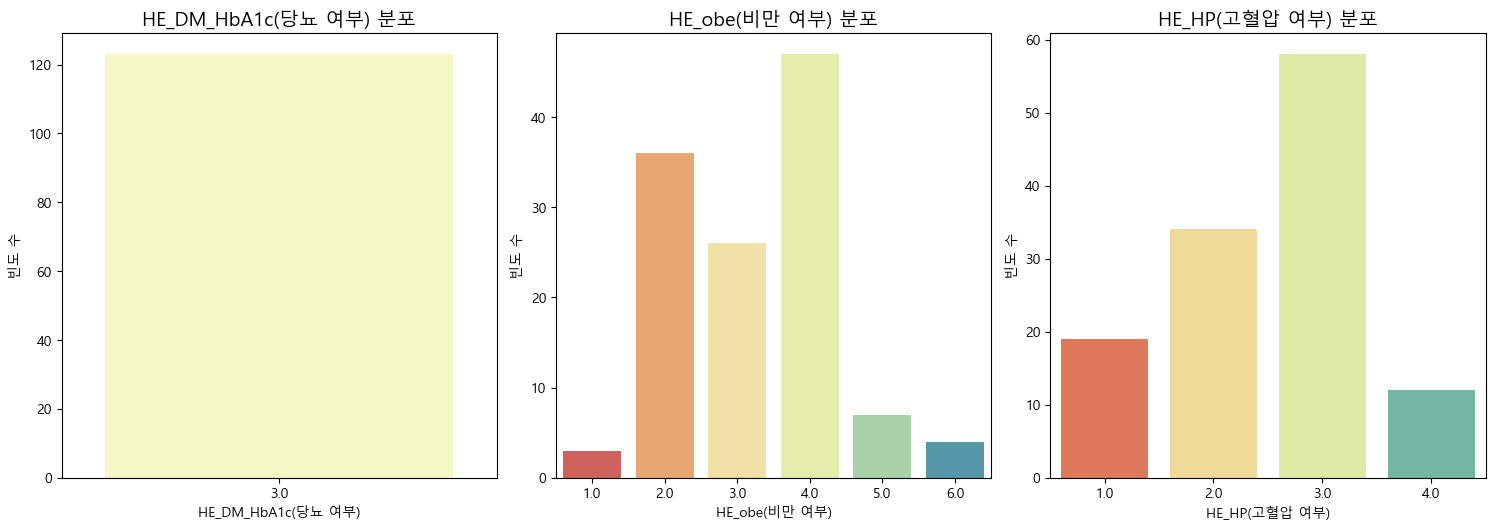

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화할 변수 리스트
targets = ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']
column_labels = {
    'HE_DM_HbA1c': 'HE_DM_HbA1c(당뇨 여부)',
    'HE_obe': 'HE_obe(비만 여부)',
    'HE_HP': 'HE_HP(고혈압 여부)'
}

# 서브플롯 설정 (2행 4열: 8개의 칸 중 3개 사용)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # 2차원 → 1차원 평탄화

# 각 변수에 대해 countplot 그리기
for i, var in enumerate(targets):
    sns.countplot(x=var, data=data, palette="Spectral", ax=axes[i])
    axes[i].set_title(f"{column_labels[var]} 분포", fontsize=14)
    axes[i].set_xlabel(column_labels[var])
    axes[i].set_ylabel('빈도 수')

# 사용하지 않는 subplot 숨기기
for j in range(len(targets), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


결과 : 경계형 당뇨인 사람은 대부분 치료를 하고 있더라는 뜻

당뇨인데 치료 안 한 사람을 드랍

In [35]:
data = pd.read_csv("C:/건강검진/health_checkup/JDM/2022년~2023년/건강조사_2012~2022_통합.csv") # 당뇨 치료

In [36]:
# 당뇨병이거나 전단계인데 치료를 하고 있는 사람은 제거
data = data[~((data['HE_DM_HbA1c'].isin([2, 3])) & (data['DE1_3'] == 1))]

In [37]:
import pandas as pd

# 남기고 싶은 컬럼 리스트
columns_to_keep = [
    'ID','year','age','sex','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1',
    'HE_Upro', 'HE_glu', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt',
    # 'L_OUT_FQ', 
    # 'BP1','BD1_11', 'BS3_2', 'BE5_1', 
    'HE_obe', 'HE_HP', 'HE_DM_HbA1c',
    'DE1_dg', 'DI1_dg',
    'DE1_3'
]

# 원래 데이터프레임이 df일 때
data = data[columns_to_keep]

In [38]:
def iqr_clip(series, lower_quantile=0.25, upper_quantile=0.75, clip_range=1.5):
    q1 = series.quantile(lower_quantile)
    q3 = series.quantile(upper_quantile)
    iqr = q3 - q1
    lower_bound = q1 - clip_range * iqr
    upper_bound = q3 + clip_range * iqr
    return series.clip(lower=lower_bound, upper=upper_bound)

# 적용
data['HE_glu'] = iqr_clip(data['HE_glu'])
data['HE_alt'] = iqr_clip(data['HE_alt'])

# HE_DM_HbA1c
if 'HE_DM_HbA1c' in data.columns:
    data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DE1_dg' in data.columns:
        print(f"DE1_dg missing ratio: {data['DE1_dg'].isnull().mean()}")
        data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].fillna(data['DE1_dg'].map({0: 1, 1: 3}))
    # 남은 결측치는 드랍랍
    if data['HE_DM_HbA1c'].isnull().any():
        data = data[data['HE_DM_HbA1c'].notnull()]
    print(f"HE_DM_HbA1c NaN count after: {data['HE_DM_HbA1c'].isnull().sum()}")

# HE_obe
if 'HE_obe' in data.columns:
    data['HE_obe'] = data['HE_obe'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'HE_BMI' in data.columns:
        # BMI가 KNN 대체된 경우 표시
        data['HE_BMI_imputed'] = data['HE_BMI'].isnull().astype(int)
        data['HE_obe'] = data.apply(
            lambda row: row['HE_obe'] if pd.notna(row['HE_obe']) else (
                1 if row['HE_BMI'] < 18.5 else
                2 if row['HE_BMI'] < 25 else
                3 if row['HE_BMI'] < 30 else
                4 if row['HE_BMI'] < 35 else
                5 if row['HE_BMI'] < 40 else
                6
            ),
            axis=1
        )
    # 남은 결측치는 드랍랍
    if data['HE_obe'].isnull().any():
        data = data[data['HE_obe'].notnull()]
    print(f"HE_obe NaN count after: {data['HE_obe'].isnull().sum()}")

# HE_HP
if 'HE_HP' in data.columns:
    data['HE_HP'] = data['HE_HP'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DI1_dg' in data.columns:
        print(f"DI1_dg missing ratio: {data['DI1_dg'].isnull().mean()}")
        data['HE_HP'] = data['HE_HP'].fillna(data['DI1_dg'].map({0: 1, 1: 4}))
    # 남은 결측치는 드랍랍
    if data['HE_HP'].isnull().any():
        data = data[data['HE_HP'].notnull()]
    print(f"HE_HP NaN count after: {data['HE_HP'].isnull().sum()}")


#결측치 비율 낮은 변수 처리
# low_missing_columns = [
#     'DI1_dg', 
#     'DE1_dg', 
# ]
continuous_columns = ['HE_wt', 'HE_ht', 'HE_BMI']  # 연속형 변수

#for col in low_missing_columns + continuous_columns:
for col in continuous_columns:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].replace([9, 99, 999, 88, 888, 9.0, 99.0, 999.0, 88.0, 888.0], np.nan)
        if not data[col].isnull().all():
            if col in continuous_columns:
                median_value = data[col].median()
                data[col] = data[col].fillna(median_value)
                print(f"Median for {col}: {median_value}")
            else:
                mode_series = data[col].mode(dropna=True)
                if not mode_series.empty:
                    mode_value = mode_series[0]
                    data[col] = data[col].fillna(mode_value)
                    print(f"Mode for {col}: {mode_value}")
                else:
                    print(f"No valid mode for {col}, leaving as is.")
        else:
            print(f"Column {col} is all NaN, skipping.")

# data = data[data['DE1_3'].isin([1, 2])]

#생체 지표 결측치 처리
knn_columns = [
    'HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_chol',
    'HE_HDL_st2', 'HE_TG', 'HE_LDL_drct',  'HE_crea', 'HE_Upro',
    'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI'
]
knn_data = data[knn_columns].copy()
knn_data = knn_data.replace([888, 999, 888.0, 999.0], np.nan)

# 스케일링
scaler = StandardScaler()
knn_data_scaled = scaler.fit_transform(knn_data)
knn_data_scaled = pd.DataFrame(knn_data_scaled, columns=knn_columns, index=knn_data.index)

# KNN Imputation
imputer_knn = KNNImputer(n_neighbors=5, weights="distance")
knn_imputed = imputer_knn.fit_transform(knn_data_scaled)

# 역스케일링
knn_imputed = scaler.inverse_transform(knn_imputed)
knn_imputed_data = pd.DataFrame(knn_imputed, columns=knn_columns, index=knn_data.index)
data[knn_columns] = knn_imputed_data



DE1_dg missing ratio: 0.05828055847617185
HE_DM_HbA1c NaN count after: 0
HE_obe NaN count after: 0
DI1_dg missing ratio: 0.0
HE_HP NaN count after: 0
Median for HE_wt: 62.1
Median for HE_ht: 162.6
Median for HE_BMI: 23.61548947203167


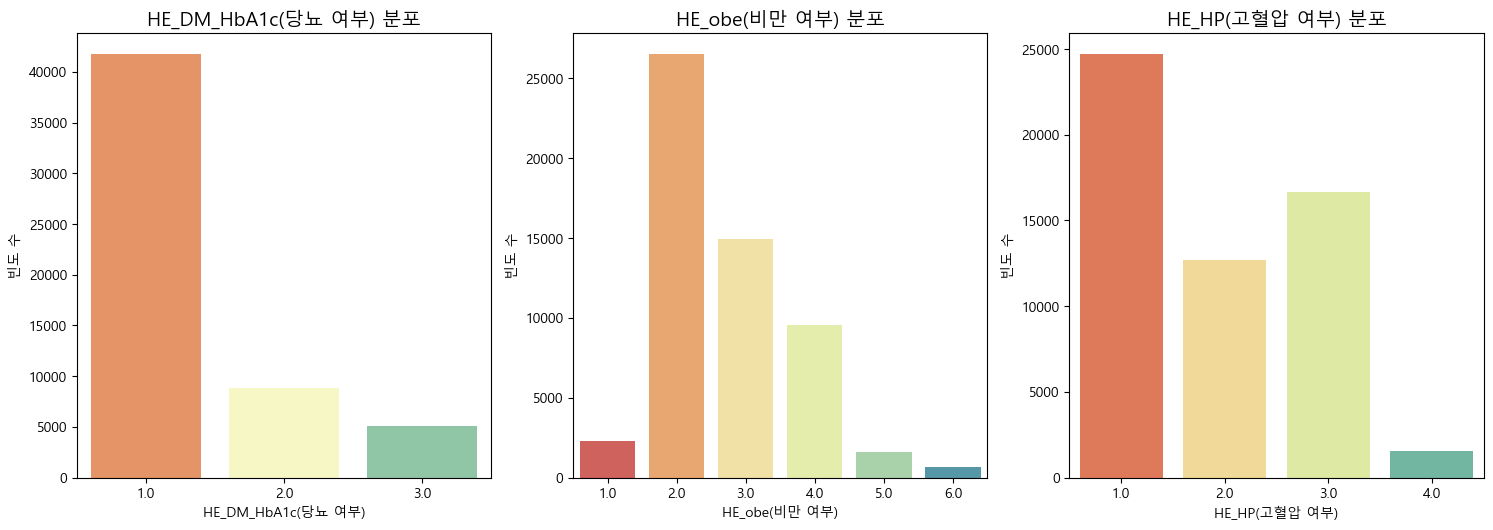

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화할 변수 리스트
targets = ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']
column_labels = {
    'HE_DM_HbA1c': 'HE_DM_HbA1c(당뇨 여부)',
    'HE_obe': 'HE_obe(비만 여부)',
    'HE_HP': 'HE_HP(고혈압 여부)'
}

# 서브플롯 설정 (2행 4열: 8개의 칸 중 3개 사용)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # 2차원 → 1차원 평탄화

# 각 변수에 대해 countplot 그리기
for i, var in enumerate(targets):
    sns.countplot(x=var, data=data, palette="Spectral", ax=axes[i])
    axes[i].set_title(f"{column_labels[var]} 분포", fontsize=14)
    axes[i].set_xlabel(column_labels[var])
    axes[i].set_ylabel('빈도 수')

# 사용하지 않는 subplot 숨기기
for j in range(len(targets), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


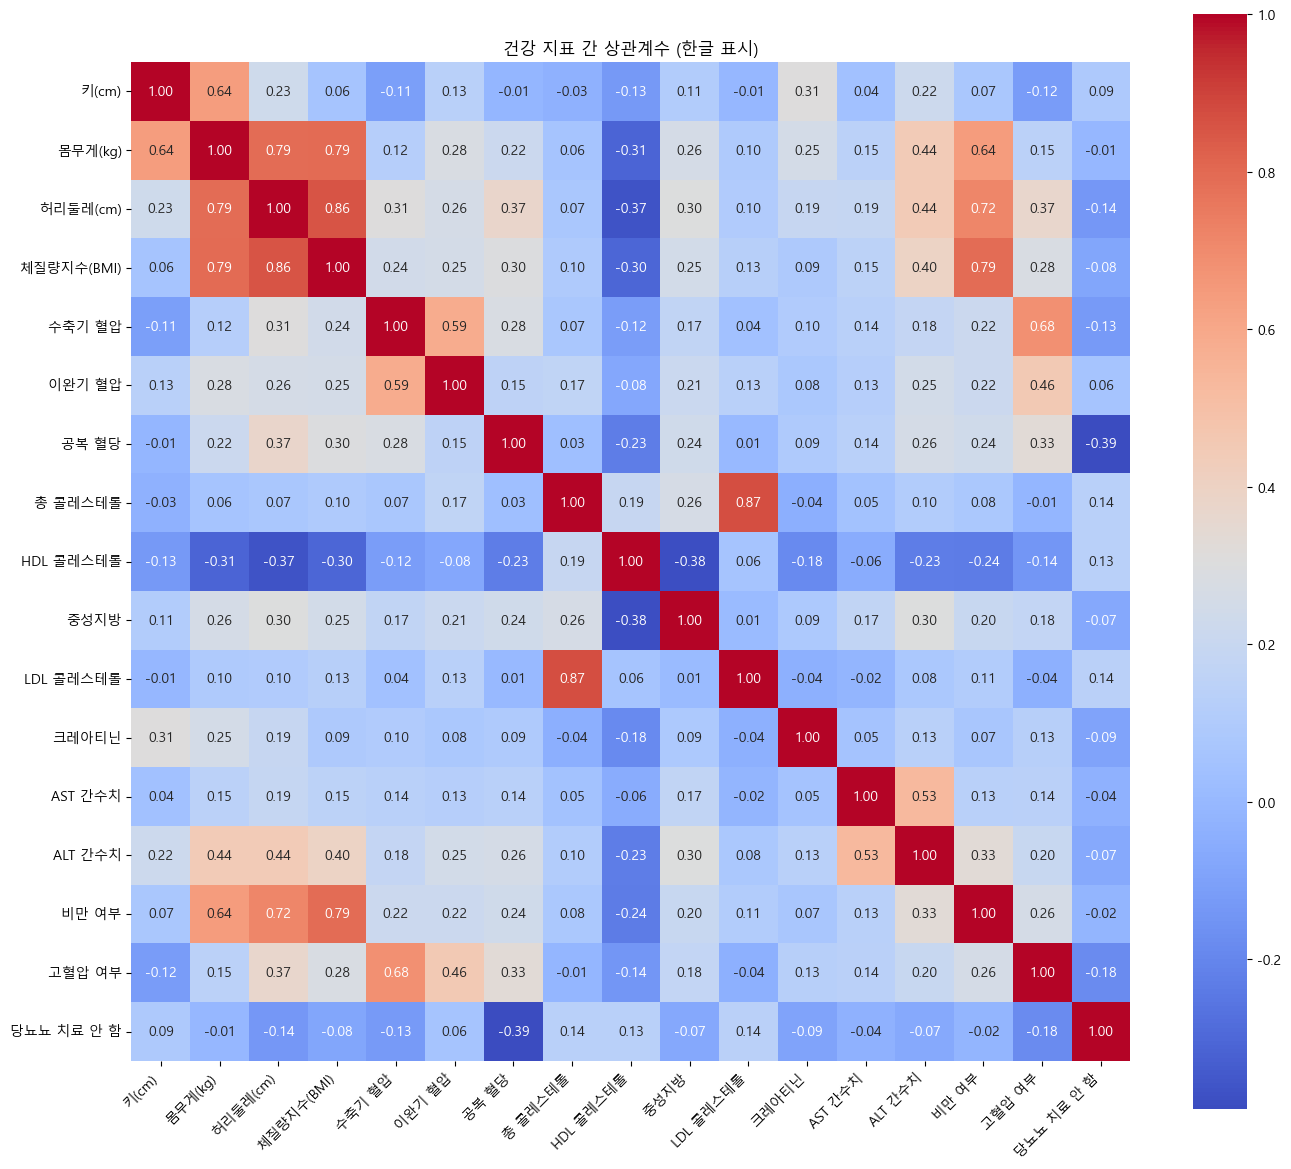

In [40]:
column_name_map = {
    'HE_ht': '키(cm)',
    'HE_wt': '몸무게(kg)',
    'HE_wc': '허리둘레(cm)',
    'HE_BMI': '체질량지수(BMI)',
    'HE_sbp1': '수축기 혈압',
    'HE_dbp1': '이완기 혈압',
    'HE_glu': '공복 혈당',
    'HE_chol': '총 콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤',
    'HE_TG': '중성지방',
    'HE_LDL_drct': 'LDL 콜레스테롤',
    'HE_crea': '크레아티닌',
    'HE_ast': 'AST 간수치',
    'HE_alt': 'ALT 간수치',
    'HE_obe': '비만 여부',
    'HE_HP': '고혈압 여부',
    'DE1_3' : '당뇨뇨 치료 안 함'
}


correlation_columns = [
    'HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1', 'HE_glu', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'DE1_3'
]

import seaborn as sns
import matplotlib.pyplot as plt

# 보고 싶은 변수만 추출
selected_columns = list(column_name_map.keys())
correlation_matrix = data[selected_columns].corr()

# 컬럼명을 한글로 변환
correlation_matrix.columns = [column_name_map[col] for col in correlation_matrix.columns]
correlation_matrix.index = [column_name_map[col] for col in correlation_matrix.index]

# 히트맵 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("건강 지표 간 상관계수 (한글 표시)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

📊 타겟 변수 상관 분석 - 당뇨병


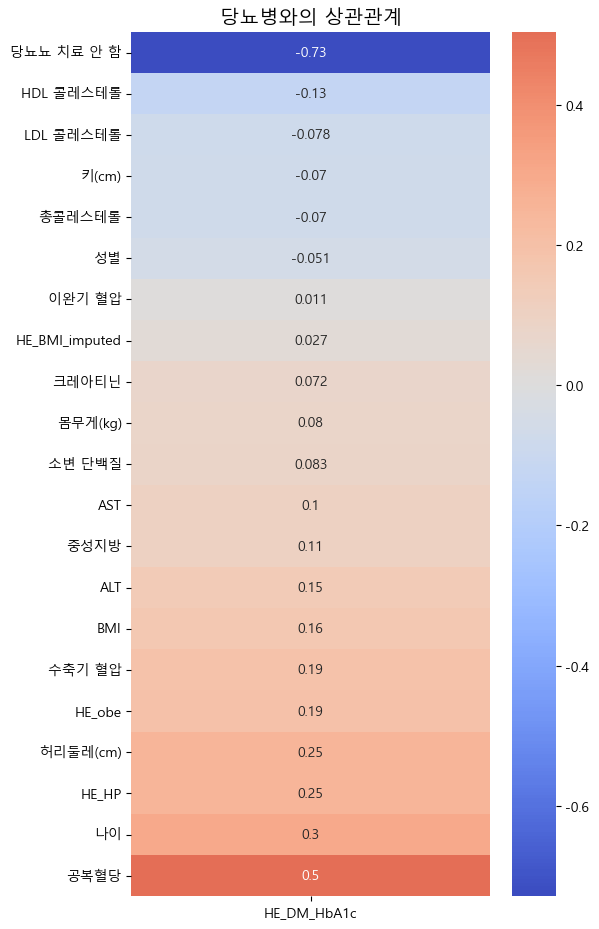

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# 변수 이름 -> 한글 매핑 사전
feature_name_ko = {
    'HE_ht': '키(cm)', 'HE_wt': '몸무게(kg)', 'HE_wc': '허리둘레(cm)', 'HE_BMI': 'BMI',
    'HE_sbp1': '수축기 혈압', 'HE_dbp1': '이완기 혈압',
    'HE_Upro': '소변 단백질', 'HE_glu': '공복혈당', 'HE_chol': '총콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤', 'HE_TG': '중성지방', 'HE_LDL_drct': 'LDL 콜레스테롤',
    'HE_crea': '크레아티닌', 'HE_ast': 'AST', 'HE_alt': 'ALT',
    'sex': '성별', 'age': '나이',
    'DE1_3' : '당뇨뇨 치료 안 함'
}

# 타겟 이름 -> 한글 매핑
target_name_ko = {

    'HE_DM_HbA1c': '당뇨병'
}

# 제외할 컬럼
exclude_cols = ['year', 'ID', 'DE1_dg', 'DI1_dg'] + list(target_name_ko.keys())

# input features 자동 지정
input_features = [col for col in data.columns if col not in exclude_cols]

for target in target_name_ko.keys():
    print(f"📊 타겟 변수 상관 분석 - {target_name_ko[target]}")
    
    # 수치형 변수만 포함한 데이터프레임
    subset = data[input_features + [target]].copy()
    subset = subset.select_dtypes(include='number')

    # 상관계수 계산
    corr_with_target = subset.corr()[[target]].drop(index=target)
    corr_with_target = corr_with_target.sort_values(by=target, ascending=True)

    # 한글 라벨로 인덱스 변환
    corr_with_target.index = [feature_name_ko.get(col, col) for col in corr_with_target.index]

    # 시각화
    plt.figure(figsize=(6, len(corr_with_target) * 0.4 + 1))
    sns.heatmap(corr_with_target, annot=True, cmap='coolwarm', center=0)
    plt.title(f"{target_name_ko[target]}와의 상관관계", fontsize=14)
    plt.tight_layout()
    plt.show()


가설 : 기존 데이터셋에는 당뇨인데 당뇨뇨치료한 사람의 수치가 껴있어 변수들간에 상관계수를 방해한다. 상관계수를 확인해 보니 기존 데이터셋과 다를것이 없다.